Dataset Shape: (768, 9)

Data Types:
 Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

Missing Values:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Statistical Summary:
        Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002

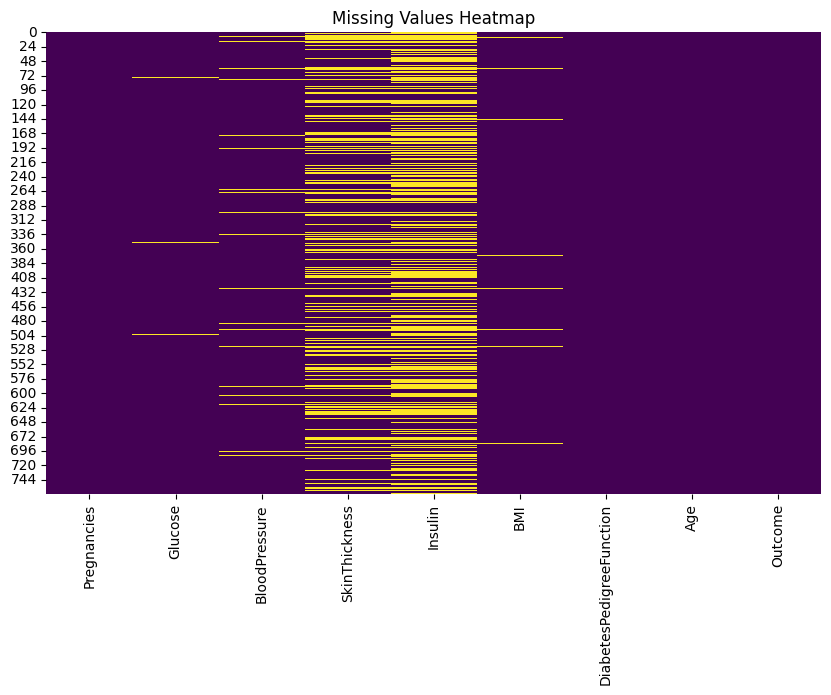


Original dataset size: 768
Cleaned dataset size: 718


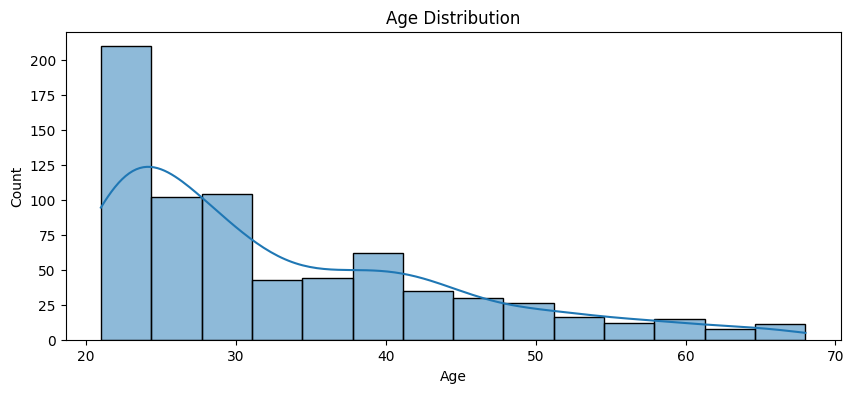

<Figure size 2000x600 with 0 Axes>

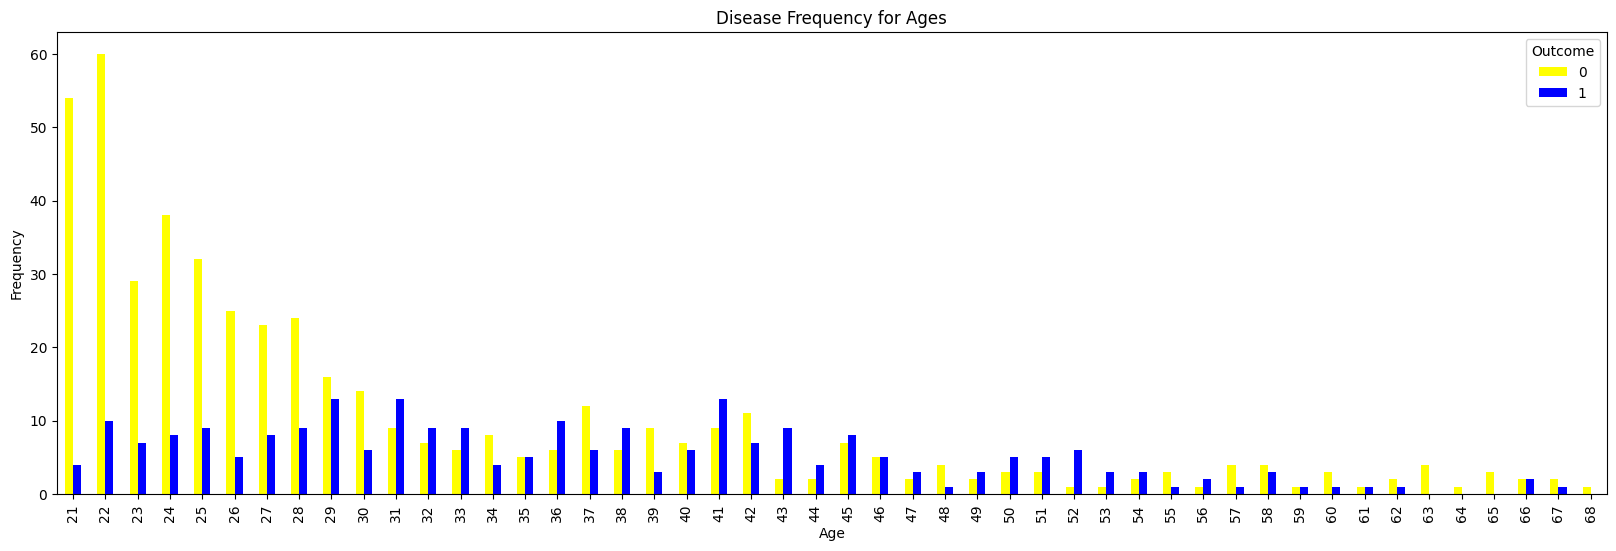

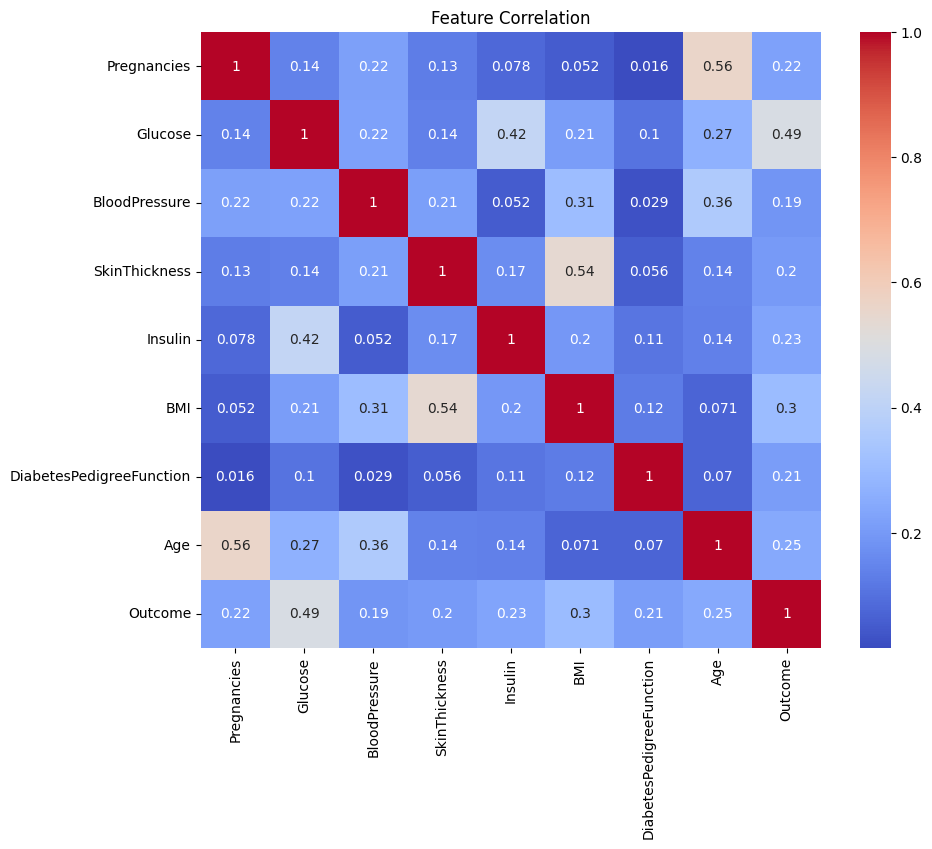


Logistic Regression Accuracy: 76.17%
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       390
           1       0.64      0.60      0.62       185

    accuracy                           0.76       575
   macro avg       0.73      0.72      0.72       575
weighted avg       0.76      0.76      0.76       575



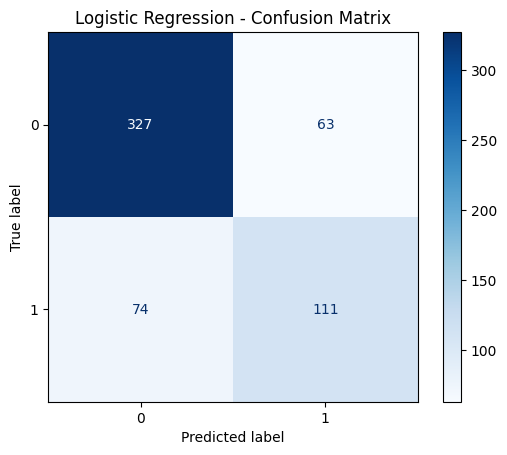


Random Forest Accuracy: 76.35%
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.83       390
           1       0.63      0.64      0.63       185

    accuracy                           0.76       575
   macro avg       0.73      0.73      0.73       575
weighted avg       0.76      0.76      0.76       575



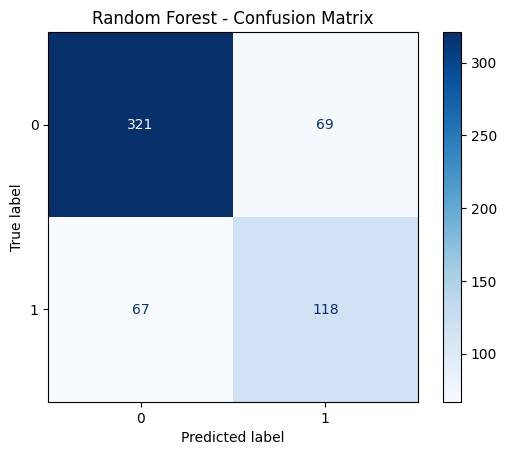


SVM Accuracy: 76.00%
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       390
           1       0.63      0.63      0.63       185

    accuracy                           0.76       575
   macro avg       0.73      0.73      0.73       575
weighted avg       0.76      0.76      0.76       575



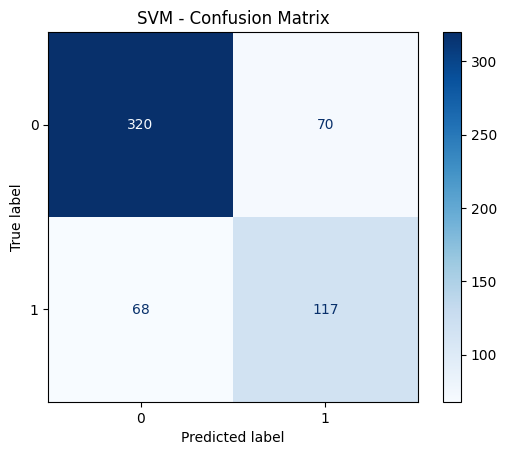


KNN Accuracy: 73.04%
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.76      0.79       390
           1       0.57      0.66      0.61       185

    accuracy                           0.73       575
   macro avg       0.70      0.71      0.70       575
weighted avg       0.74      0.73      0.74       575



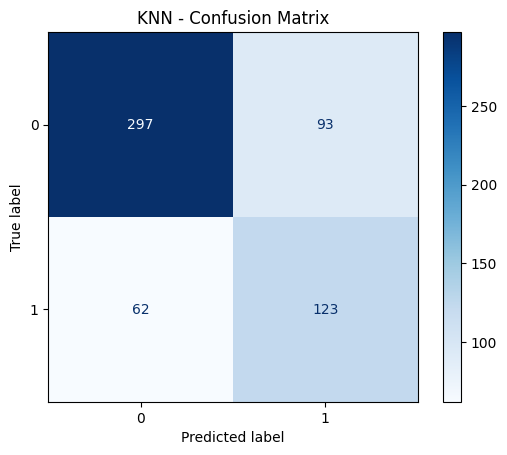


Decision Tree Accuracy: 67.48%
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.71      0.75       390
           1       0.50      0.60      0.54       185

    accuracy                           0.67       575
   macro avg       0.64      0.66      0.65       575
weighted avg       0.69      0.67      0.68       575



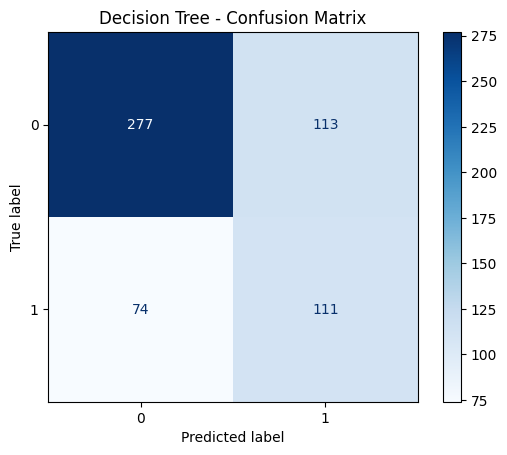

C:\Users\lucky\AppData\Local\Temp\ipykernel_4440\3079296322.py:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette="viridis")


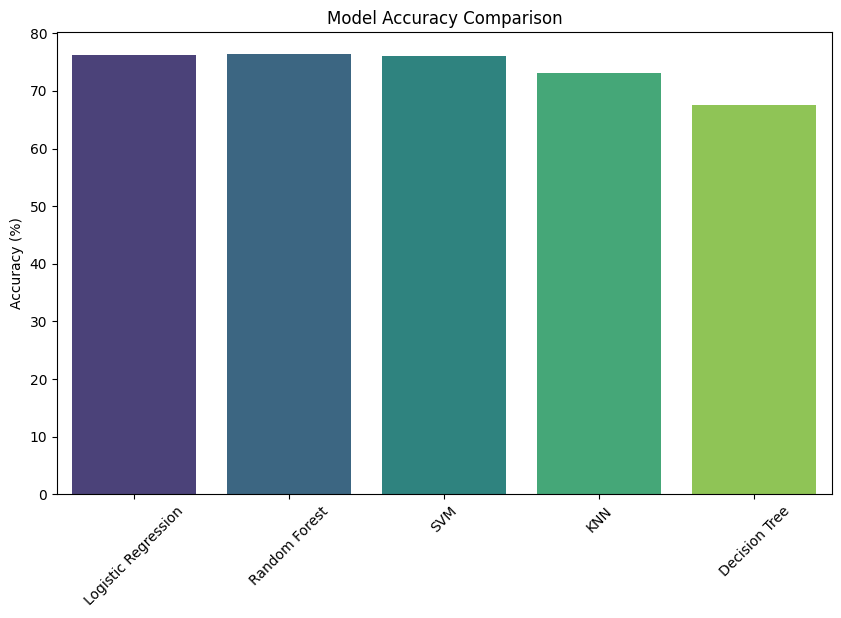


Best Parameters Found:
 {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 50}

Final Accuracy Scores:
Logistic Regression: 76.17%
Random Forest: 76.35%
SVM: 76.00%
KNN: 73.04%
Decision Tree: 67.48%


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# ----------------------------------
# Step 1: Load and inspect dataset
# ----------------------------------
df = pd.read_csv("diabetes.csv")

# Initial inspection
print("Dataset Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
print("\nStatistical Summary:\n", df.describe())

# ----------------------------------
# Step 2: Data Cleaning
# ----------------------------------

# Columns where 0 is biologically invalid
invalid_zero_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Replace 0s with NaN for better imputation
for col in invalid_zero_cols:
    df[col] = df[col].replace(0, np.nan)

# Check for missing values
print("\nMissing values after replacement:\n", df.isnull().sum())

# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

# Impute using median
df.fillna(df.median(), inplace=True)

# Additional cleaning: removing outliers using z-score
from scipy.stats import zscore

z_scores = np.abs(zscore(df))
df_clean = df[(z_scores < 3).all(axis=1)]

print("\nOriginal dataset size:", df.shape[0])
print("Cleaned dataset size:", df_clean.shape[0])

# ----------------------------------
# Step 3: Visualizations
# ----------------------------------

plt.figure(figsize=(10, 4))
sns.histplot(df_clean["Age"], kde=True)
plt.title("Age Distribution")

plt.figure(figsize=(20, 6))
pd.crosstab(df_clean.Age, df_clean.Outcome).plot(kind="bar", figsize=(20, 6), color=["yellow", "blue"])
plt.title("Disease Frequency for Ages")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(df_clean.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()

# ----------------------------------
# Step 4: Train-Test Split & Scaling
# ----------------------------------

X = df_clean.drop("Outcome", axis=1)
y = df_clean["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# ----------------------------------
# Step 5: Model Setup
# ----------------------------------

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
}

accuracies = {}
best_model = None
best_accuracy = 0

# ----------------------------------
# Step 6: Training and Evaluation
# ----------------------------------

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc * 100

    print(f"\n{name} Accuracy: {acc * 100:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model

# ----------------------------------
# Step 7: Model Comparison
# ----------------------------------

plt.figure(figsize=(10, 6))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette="viridis")
plt.xticks(rotation=45)
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.show()

# ----------------------------------
# Step 8: Hyperparameter Tuning (for best model type)
# ----------------------------------

if isinstance(best_model, RandomForestClassifier):
    param_grid = {
        "n_estimators": [50, 100, 150],
        "max_depth": [3, 5, 10],
        "criterion": ["gini", "entropy"],
    }
elif isinstance(best_model, KNeighborsClassifier):
    param_grid = {
        "n_neighbors": [3, 5, 7],
        "weights": ["uniform", "distance"],
    }
elif isinstance(best_model, SVC):
    param_grid = {
        "C": [0.1, 1, 10],
        "kernel": ["linear", "rbf"],
    }
else:
    param_grid = {}

if param_grid:
    grid = GridSearchCV(best_model, param_grid, cv=3, n_jobs=-1)
    grid.fit(X_train, y_train)
    print("\nBest Parameters Found:\n", grid.best_params_)

# ----------------------------------
# Step 9: Summary
# ----------------------------------

print("\nFinal Accuracy Scores:")
for model_name, score in accuracies.items():
    print(f"{model_name}: {score:.2f}%")
